In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt

tf.__version__ 

'2.4.1'

In [2]:
scanType = 2  # 1--Alpinion || 2-- PICMUS17

if scanType == 1:
    Nx, Nz = 512, 512 
    testFilepath = r'E:\Desktop\internshipDeepUS\04_16_2021_(ABLE)\Test_ABLE\Alpinion.mat'
    testNames = ["contrast","resolution"]
    predictedFile = "Alpinion_predicted.mat"
elif scanType == 2:
    Nx, Nz =  387, 609
    testFilepath = r'E:\Desktop\internshipDeepUS\04_16_2021_(ABLE)\Test_ABLE\PICMUS17.mat'
    testNames = ['in_vitro_type1','in_vitro_type2','in_vitro_type3','numerical']
    predictedFile = "PICMUS17_predicted.mat"
    
pixels = Nx * Nz
testFile = scio.loadmat(testFilepath)

# 2. Test the model on Alpinion/PICMUS17 datasets (nbpw=1)

## 2-1 Load model and weights

In [3]:
Ne = 128  # Number of transducer elements

# Model can not be loaded directly because the self-defined function "loss_SMSLE" and "loss_unity" can not be recognized
# So here build the model again and load the saved weights.

def antirectifier(x):   #copy from https://www.tensorflow.org/.../keras/layers/Lambda
    x -= K.mean(x, axis=1, keepdims=True)
    x = K.l2_normalize(x, axis=1)
    pos = K.relu(x)
    neg = K.relu(-x)
    return K.concatenate([pos, neg], axis=1)
def loss_SMSLE(y_true, y_pred, scale=1.):
    first_log = K.log(K.clip(K.abs(y_pred[:, :1]) * scale, K.epsilon(), None) + 1.) * K.sign(y_pred[:, :1])
    second_log = K.log(K.clip(K.abs(y_true[:, :1]) * scale, K.epsilon(), None) + 1.) * K.sign(y_true[:, :1])
    return K.mean(K.square(first_log - second_log), axis=-1)
def loss_unity(y_true, y_pred):
    return K.mean( K.square(y_pred - y_true),  axis=0 )

_input = keras.Input(shape=(Ne,))
x = keras.layers.Dense(Ne)(_input)
x = keras.layers.Lambda(antirectifier)(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(Ne/4)(x)
x = keras.layers.Lambda(antirectifier)(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(Ne/4)(x)
x = keras.layers.Lambda(antirectifier)(x)
x = keras.layers.Dropout(0.2)(x)

weights = keras.layers.Dense(Ne, name = "weights")(x)  # no activation is applied
sumWeights = keras.layers.Lambda(lambda x: K.sum(x, axis=1, keepdims=True), name = "sumWeights")(weights) 
multiplied = keras.layers.Multiply()([_input, weights])
output = keras.layers.Lambda(lambda x: K.sum(x, axis=1, keepdims=True), name="output")(multiplied)

model = keras.Model(
    inputs=[_input],
    outputs=[output,sumWeights],
)

model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-3),
    loss={"output":loss_SMSLE, "sumWeights":loss_unity},
    loss_weights=[1,1]
)

# The model weights (that are considered the best) are loaded into the model.
checkpoint_filepath = '../tmp/checkpoint'
model.load_weights(checkpoint_filepath)

## 2-2. Do prediction and save predicted data

In [4]:
y_predict = np.zeros((pixels,len(testNames)))

for i in range(len(testNames)):
    temp = np.squeeze(model.predict(x = testFile[testNames[i]]))  # temp.shape = (2,NumberOfPixels)
    y_predict[:,i] = temp[0,:]                                    # the second row is output_sumWeights
    
scio.savemat(predictedFile, {testNames[i]: y_predict[:,i] for i in range(len(testNames))})

## 2-3. Show one predicted image in a easy way

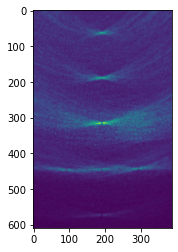

In [9]:
# the complete code of displaying images is in MATLAB

y_predict_max = y_predict[:,1].max()
y_predict_log = 20.*np.log10((1./y_predict_max)*y_predict[:,1]+1)

y_img_data = np.reshape(y_predict_log, (Nz,Nx))

plt.imshow(y_img_data)
#plt.savefig(filename)